# Creando una GCN con Spektral

En este _notebook_ vamos a aprender a crear una GCN con Spektral. Para esto, vamos a usar el _dataset_ Zachary's Karate Club (puedes leer sobre este dataset en [este link](https://en.wikipedia.org/wiki/Zachary%27s_karate_club)), que corresponde a un grafo que tiene ciertos _clusters_. Lo que vamos a hacer después es.

1. Hacer aprendizaje semi-supervisado: vamos a etiquetar cuatro nodos de los 34 del grafo para obtener una clasificación para todos los nodos del grafo. Para esto vamos a usar la arquitectura de Kipf.
2. Vamos a crear _embeddings_ para los nodos.

La idea de usar este _dataset_ es replicar los resultados mostrados en [este post](https://tkipf.github.io/graph-convolutional-networks/).

## Cargando los datos

Primero vamos a partir importando las librerías y los datos.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse

#Keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

# Spektral
from spektral.data.dataset import Dataset
from spektral.data.graph import Graph
from spektral.layers import GCNConv
from spektral.utils.convolution import gcn_filter

Nuestros datos están en los siguientes `.csv`:

1. `A_karate.csv` contiene las aristas del grafo.
2. `y_karate.csv` contiene las 4 etiquetas que vamos a utilizar al partir. Ojo que cada nodo corresponde a un _cluster_ distinto.

In [2]:
karate_df = pd.read_csv("A_karate.csv")
y = pd.read_csv("y_karate.csv")

Veamos el _dataset_.

In [3]:
karate_df

,src,dst
0,1,2
1,1,3
2,2,3
3,1,4
4,2,4
...,...,...
73,29,34
74,30,34
75,31,34
76,32,34


En el grafo cada nodo es una persona y las aristas representan cada par de personas que tenían algún tipo de interacción en el club de karate. Por lo mismo, este grafo es no dirigido. 

Ahora en base a esto, vamos a crear la matriz de adyacencia.

In [4]:
A = np.zeros((34, 34))

for edge in karate_df.values:
    A[edge[0] - 1, edge[1] - 1] = 1
    A[edge[1] - 1, edge[0] - 1] = 1

A = sparse.csr_matrix(A)

Ahora viene una parte muy importante: **debemos normalizar la matriz de adyacencia**. Esta es una técnica habitual en el área de _Graph Neural Networks_. En este caso usaremos la normalización típica de la arquitectuuura de Kipf:

$$
A' = \hat D^{-1/2} \hat A \hat D^{-1/2}
$$

Para realizar la transformación usamos la función `gcn_filter` de `spektral`.

In [5]:
A_normalized = gcn_filter(A)

Ahora vamos a crear los pesos de nuestros _samples_. Ya que solo conocemos 4 etiquetas, vamos a pedirle a Keras/Spektral que ignore los samples no etiquetados. Para esto vamos a ver las columnas que están etiquetadas.

In [6]:
y

,0,1,2,3
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0


Como vemos, hay 4 ejemplos etiquetados. Ahora vamos a encontrar sus posiciones.

In [7]:
y.sum(axis=1)[y.sum(axis=1) == 1]

5     1.0
17    1.0
28    1.0
29    1.0
dtype: float64

Son las posiciones 5, 17, 28 y 29.

Ahora vamos a setear los pesos de esas instancias. **Ojo**: la suma de todos los pesos debe ser 1.

In [8]:
examples = y.sum(axis=1)[y.sum(axis=1) == 1].keys()

sample_weights = np.zeros(34)
sample_weights[examples[0]] = 0.25
sample_weights[examples[1]] = 0.25
sample_weights[examples[2]] = 0.25
sample_weights[examples[3]] = 0.25
sample_weights

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.25, 0.  , 0.  , 0.  ,
       0.  ])

## Creando nuestro Dataset

Ahora vamos a cargar el _dataset_. Para esto tenemos que crear una clase que hereda de la clase `Dataset` de Spektral. Implementamos su función `read` que debe retornar la lista de grafos, que en este caso solamente es 1 grafo \[1\].

El grafo debe recibir las _features_ de los nodos, la matriz de adyacencia y las etiquetas. En este caso, los nodos **no tienen _features_** por lo que usamos la matriz identidad (de $34\times34$) como matriz de _features_.

---

\[1\]: Aquí estamos clasificando nodos, pero recordemos que hay otros tipos de problemas resueltos con GNNs que necesitan más grafos, por ejemplo, al hacer clasificación de grafos.

In [9]:
class KarateDataset(Dataset):
    def read(self):
        # X represent the features of nodes
        X = np.zeros((34, 34))
        
        # Here we create an identity matrix
        for i in range(34):
            X[i, i] = 1
        
        # We return a list with a single graph
        return [Graph(x=X, a=A_normalized, y=y)]

ds = KarateDataset()

## Definiendo y entrenando nuestro modelo

Ahora instanciamos nueustro modelo. Tal como se describe en el [paper que presenta la arquitectura de Kipf](https://arxiv.org/abs/1609.02907), vamos a usar:

1. Dos _hidden layers_ de 4 neuronas
2. Una _hidden layer_ de 2 neuronas que nos dará nuestro _embedding_.
3. Una capa de _output_, que tiene una activación _softmax_ hará la clasificación.

Ojo que la capa anterior a la de _output_ tiene una activación `tanh`, que es como una sigmoide que va entre -1 y 1. Esto hace que cada una de sus dos neuronas tenga un número entre -1 y 1 que pondrá a cada nodo en un plano de dos dimensiones.

In [10]:
# All the parameters were chosen according to https://arxiv.org/abs/1609.02907
class GCNExample(Model):
    def __init__(self, n_hidden, n_labels, embedding_size):
        super().__init__()
        self.graph_conv = GCNConv(n_hidden, activation='tanh')
        self.graph_conv_2 = GCNConv(n_hidden, activation='tanh')
        self.graph_conv_3 = GCNConv(embedding_size, activation='tanh')
        self.dense = Dense(n_labels, activation='softmax')

    def call(self, inputs):
        X, A = inputs
        out = self.graph_conv([X, A])
        out = self.graph_conv_2([out, A])
        out = self.graph_conv_3([out, A])
        out = self.dense(out)

        return out
    
    def get_embedding(self, X, A):
        out = self.graph_conv([X, A])
        out = self.graph_conv_2([out, A])
        out = self.graph_conv_3([out, A])

        return out
    
gcn = GCNExample(4, 4, 2)
gcn.compile(Adam(learning_rate=0.01), 'categorical_crossentropy')

Ahora instanciamos un `Loader`, que es la forma que tiene Spektral de pasar los datos. Esto esconde un montón de complejidad, sobre todos para problemas más complejos de _graph classification_.

In [11]:
from spektral.data import SingleLoader

# The arguments are the Dataset and the weights
loader = SingleLoader(ds, sample_weights=sample_weights)

Ahora entrenamos nuestro modelo.

In [12]:
gcn.fit(loader.load(), steps_per_epoch=loader.steps_per_epoch, epochs=300)

Epoch 1/300
1/1 [==============================] - 1s 1s/step - loss: 0.0414
Epoch 2/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0412
Epoch 3/300
1/1 [==============================] - 0s 4ms/step - loss: 0.0409
Epoch 4/300
1/1 [==============================] - 0s 8ms/step - loss: 0.0407
Epoch 5/300
1/1 [==============================] - 0s 26ms/step - loss: 0.0406
Epoch 6/300
1/1 [==============================] - 0s 16ms/step - loss: 0.0404
Epoch 7/300
1/1 [==============================] - 0s 5ms/step - loss: 0.0402
Epoch 8/300
1/1 [==============================] - 0s 9ms/step - loss: 0.0400
Epoch 9/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0398
Epoch 10/300
1/1 [==============================] - 0s 7ms/step - loss: 0.0396
Epoch 11/300
1/1 [==============================] - 0s 6ms/step - loss: 0.0394
Epoch 12/300
1/1 [==============================] - 0s 4ms/step - loss: 0.0392
Epoch 13/300
1/1 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 105/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 106/300
1/1 [==============================] - 0s 4ms/step - loss: 0.0139
Epoch 107/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 108/300
1/1 [==============================] - 0s 5ms/step - loss: 0.0133
Epoch 109/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 110/300
1/1 [==============================] - 0s 6ms/step - loss: 0.0127
Epoch 111/300
1/1 [==============================] - 0s 6ms/step - loss: 0.0124
Epoch 112/300
1/1 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 113/300
1/1 [==============================] - 0s 5ms/step - loss: 0.0118
Epoch 114/300
1/1 [==============================] - 0s 4ms/step - loss: 0.0115
Epoch 115/300
1/1 [==============================] - 0s 4ms/step - loss: 0.0112
Epoch 116/300
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 207/300
1/1 [==============================] - 0s 11ms/step - loss: 0.0019
Epoch 208/300
1/1 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 209/300
1/1 [==============================] - 0s 12ms/step - loss: 0.0018
Epoch 210/300
1/1 [==============================] - 0s 12ms/step - loss: 0.0018
Epoch 211/300
1/1 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 212/300
1/1 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 213/300
1/1 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 214/300
1/1 [==============================] - 0s 10ms/step - loss: 0.0017
Epoch 215/300
1/1 [==============================] - 0s 29ms/step - loss: 0.0017
Epoch 216/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 217/300
1/1 [==============================] - 0s 29ms/step - loss: 0.0017
Epoch 218/300
1/1 [=============================

## Prediciendo con el modelo y obteniendo embeddings

Ahora lo que haremos será predecir con nuestro modelo. Obtendremos la predicción de la clase para cada uno de los nodos.

In [13]:
y_pred = gcn.predict(loader.load(), steps=1).argmax(axis=1)
y_pred

array([0, 0, 3, 0, 2, 2, 2, 0, 1, 3, 2, 0, 0, 0, 1, 1, 2, 0, 1, 0, 1, 0,
       1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1])

Ahora lo que haremos será obtener el embedding de la red. Esto lo haremos con la función definida por nosotros `get_embedding`, que nos da los valores de la penúltima capa.

In [14]:
# Our features are the identity again
X = np.zeros((34, 34))
for i in range(34):
    X[i, i] = 1

# We call the model with the features and our normalized adjacency matrix
embeddings = gcn.get_embedding(X, A_normalized.todense())

# Since it is a Tensorflow Tensor, we transform the answer to a numpy array
embeddings = embeddings.numpy()

# We create a DataFrame
embeddings = pd.DataFrame(embeddings)
embeddings.columns = ['x', 'y']
embeddings

,x,y
0,0.914716,0.999063
1,0.997546,0.980972
2,-0.626667,-0.895610
3,0.925111,0.954165
4,-0.938892,0.989481
5,-0.988418,0.992464
6,-0.988148,0.992576
7,0.806799,0.857228
8,0.160997,-0.952697
9,-0.949249,-0.981627


## Visualizando los embeddings

Ahora vamos a visualizar nuestros embeddings. Para esto, vamos a adjuntar la predicción para colorear por tipo.

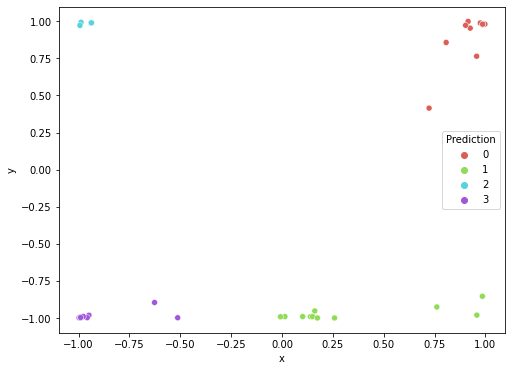

In [19]:
embeddings["Prediction"] = y_pred

plt.figure(figsize=(8,6))
ax = sns.scatterplot(data=embeddings, x='x', y='y', hue="Prediction", palette=sns.color_palette("hls", 4))

## Visualizando el grafo y la clasificación

Ahora vamos a visualizar el grafo para descubrir visualmente que tan buena fue la clasificación. Para esto vamos a usar la librería `networkx`, que permite instanciar y visualizar grafos.

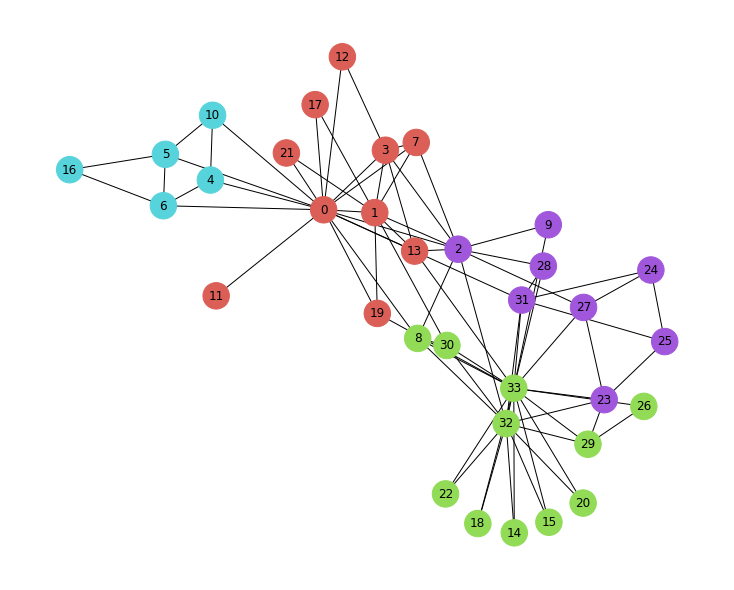

In [47]:
G = nx.Graph()

G.add_nodes_from(list(range(0, 34)))
G.add_edges_from((karate_df - 1).values)

# We select the seaborn palette
# We map each prediction to a color from the palette
palette = sns.color_palette("hls", 4).as_hex()
color_map = embeddings['Prediction'].map(lambda x: palette[x]).values

plt.figure(figsize=(10, 8))
nx.draw(G, node_size=700, node_color=color_map, with_labels=True)